In [0]:
from fastai import *
from fastai.vision import *

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
!cp /gdrive/'My Drive'/dc99623a-c-vista_data.zip ./

In [5]:
!unzip dc99623a-c-vista_data.zip

Archive:  dc99623a-c-vista_data.zip
  inflating: sample.csv              
 extracting: test_final.zip          
  inflating: train.csv               
 extracting: train_final.zip         


In [0]:
!unzip -qq -d 'train/' train_final.zip
!unzip -qq -d 'test/' test_final.zip

In [0]:
import pandas as pd
train_df = pd.read_csv('train.csv')

In [8]:
train_df.head()

,id,label
0,f1.png,10
1,f2.png,13
2,f3.png,7
3,f4.png,7
4,f5.png,7


In [0]:
src = (ImageList.from_df(train_df, path='train/')
       .split_by_rand_pct(0.05)
       #.split_none()
       .label_from_df())

In [0]:
tfms = get_transforms(do_flip=True,max_rotate=45.0, max_zoom=2, max_lighting=0.22, max_warp=0.0, p_affine=0.75,
                      p_lighting=0.75)

In [0]:
data = (src.transform(tfms, size=299,padding_mode='reflection',resize_method=ResizeMethod.SQUISH)
        .databunch(path='.', bs=8, device= torch.device('cuda:0')).normalize(imagenet_stats))
df = pd.DataFrame(columns=['id'])
submit = pd.read_csv('sample.csv')
df['id'] = submit['id']
data.add_test(ImageList.from_df(df, path='test/'))

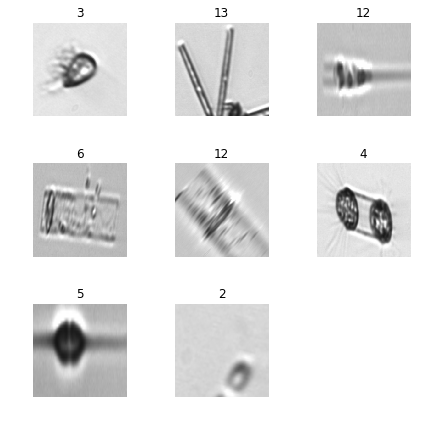

In [12]:
data.show_batch(rows=4, figsize=(6,6))

In [13]:
data.classes

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [14]:
learn = cnn_learner(data=data, base_arch=models.resnet152, metrics=[accuracy],
                    callback_fns=ShowGraph)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth
100%|██████████| 241530880/241530880 [00:02<00:00, 102156768.12it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-04
Min loss divided by 10: 2.29E-03


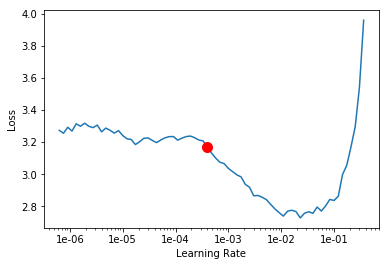

In [15]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,1.466290,0.891405,0.718868,06:06


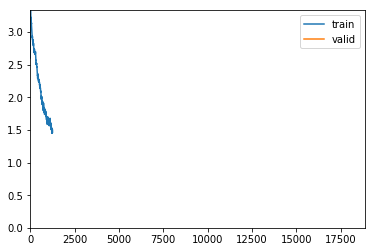

In [0]:
lr = 3.98e-04
learn.fit_one_cycle(15,lr,wd=0.2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-06
Min loss divided by 10: 6.31E-08


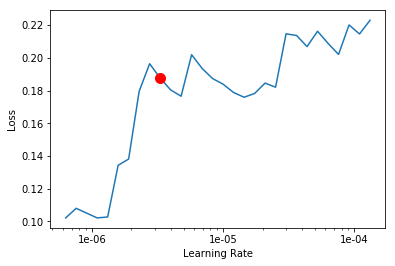

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,0.286418,0.087751,0.969811,05:57


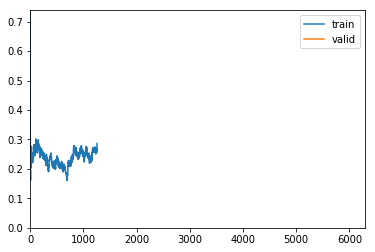

KeyboardInterrupt: ignored

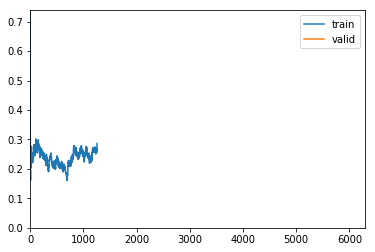

In [0]:
learn.fit_one_cycle(5,5e-6,wd=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.242847,0.108603,0.960377,05:26
1,0.267322,0.098571,0.967925,05:31
2,0.251094,0.103248,0.964151,05:31
3,0.191566,0.091189,0.969811,05:32
4,0.220359,0.079867,0.979245,05:32


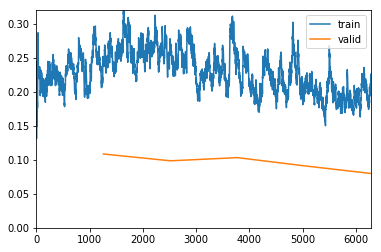

In [0]:
learn.freeze_to(-2)
lr = 3e-3
learn.fit_one_cycle(5,slice(5e-07, lr/20),wd=0.1)

In [0]:
import numpy

In [0]:
test.shape

(15984, 299, 299, 3)

In [0]:
il = ImageList('test/*.png')

In [0]:
data = ImageDataBunch.create_from_ll(src, ds_tfms=tfms,size=299, bs=16).normalize(imagenet_stats)


In [0]:
test_preds = np.exp(learn.TTA(ds_type=DatasetType.Test)[0].numpy())

In [0]:
test_preds = np.argmax(test_preds,axis=1) + 1 

In [0]:
pred = np.exp(learn.get_predict(ds_type=DatasetType.Test)[0].numpy())

AttributeError: ignored

In [0]:
 submit['label'] = test_preds

In [0]:
preds,_ = learn.TTA(ds_type=DatasetType.Test)

NameError: ignored

In [0]:
submit.to_csv('submission.csv',index=False)